## notebook for plotting the citation patterns of a single conference

revisions from v0:

* DONE - fix venue name entry: CoRR
* DONE - have venue name indicate conf or journal (-c, -j suffix) 
* DONE - clean up the data structure and groupbys 
* normalize heatmaps, compute entropy
* export one single graph for incoming/outgoing citations
* generate network layout for the graph above
* DONE - auto save and name the plots

processing

* figs for PLDI
* figs for ML conferences
* figs for ACM MM

* DONE new MAG data


In [1]:
import os, sys
import pandas as pd
from datetime import datetime 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import json

# initilize plotting packages: seaborn

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

%matplotlib inline

#conf = 'WSDM'
#conf = 'PLDI'
conf = 'NIPS'
#conf = 'MM'
data_dir = './data'

plot_dir = '/Users/xlx/SkyDrive/Repositories/cmLab/static/img/citation' #'./plots'
post_dir = '/Users/xlx/SkyDrive/Repositories/cmLab/content/citation'

if not os.path.exists(os.path.join(plot_dir, conf)):
    os.makedirs(os.path.join(plot_dir, conf))


input data: 

* dataframes: paper, citing, cited
* conference + journal --> df_venue, displaynames

In [2]:
d = pickle.load( open(os.path.join(data_dir, 'cite_records.'+conf+".pkl"), 'rb') )
# pickle.dump({"name":c, 'citing':dfx_citing, "cited":dfx_cited, "paper":df_paper}, 
#           open(os.path.join(data_dir, 'cite_records.'+c+".pkl"), 'wb') ) 

df_citing = d['citing']
df_cited = d['cited']
df_paper = d['paper']

print(len(df_paper), len(df_citing), len(df_cited))

6483 38246 131082


In [3]:
conf_file = os.path.join(data_dir, 'Conferences.txt')
conf_df = pd.read_table(conf_file, header=None, names=['ConfID', 'Abbrv', 'FullName'])

jnl_file = os.path.join(data_dir, 'Journals.txt')
jnl_df = pd.read_table(jnl_file, header=None, names=['JournalID', 'FullName'])

print("{} conferences and {} journals found in db".format(len(conf_df), len(jnl_df)) )

num_conf = len(conf_df)

df_venue = pd.concat([ conf_df[['ConfID', 'Abbrv']].rename(columns = {'Abbrv':'VenueName', 'ConfID':"VenueID"}), 
                    jnl_df.rename(columns = {'FullName':'VenueName', 'JournalID':"VenueID"}, 
                                  index = dict(zip(list(jnl_df.index), [x+num_conf for x in list(jnl_df.index)])), 
                                  inplace=False) ], 
                    keys=['c', 'j'])

print( df_venue.head() ) 
print (df_venue.tail())
print(len(df_venue))

# find the id of the current conference
row = conf_df.loc[conf_df['Abbrv'] == conf]
conf_id = list(row['ConfID'])[0]

1283 conferences and 23404 journals found in db
      VenueID VenueName
c 0  42C0AB71      PAKM
  1  42DBFEF6       SWS
  2  42F4C8D1    ACIIDS
  3  4366C780      ICGI
  4  43742018      CTIC
          VenueID                                          VenueName
j 24682  3B5E5672                        Medicina Veterinaria-recife
  24683  3B6C2D0B                 Emj-engineering Management Journal
  24684  3B80ECF8  Eklem Hastaliklari Ve Cerrahisi-joint Diseases...
  24685  3D88A422                              Medicina-buenos Aires
  24686  3DCAB9BD                                Lecciones y Ensayos
24687


In [4]:
"""correct one acronym err as per discusion with Alex Wade at MSR -- 2016-02-24
Clinical Orthopaedics and Related Research  --> CoRR
"""

ifix = np.nonzero(df_venue['VenueName'] == "Clinical Orthopaedics and Related Research" )[0]
print("changing this entry: ")
print( df_venue.iloc[ ifix] ) 
print("to this entry: ")
df_venue.set_value(('j', ifix[0]), 'VenueName', 'CoRR')
print( df_venue.iloc[ifix] ) 


changing this entry: 
          VenueID                                   VenueName
j 19255  0B68DB42  Clinical Orthopaedics and Related Research
to this entry: 
          VenueID VenueName
j 19255  0B68DB42      CoRR


In [5]:
""" now generate dictionaries for display names: ID--> display; and VenueName--> display
"""
id2display = dict.fromkeys(list(df_venue['VenueID']))
name2display = dict.fromkeys(list(df_venue['VenueName']))

cnt = 0 
for index, row in df_venue.iterrows():
    v = row['VenueID']
    m = row['VenueName']
    m1 = m.replace('The Journal of', 'J.').replace('Journal of', 'J.').replace('Journal', 'J')
    m2 = m1.replace('Proceedings of', 'Proc.').replace('Proceedings', 'Proc')
    m3 = m2.replace('Annals of', 'A.').replace('Annals', 'A')
    m3 = m3.replace('Review', 'Rev').replace('Transactions', 'Trans')
    m3 = m3.replace('International', 'Intl').replace('National', 'Nat')
    m4 = m3 if len(m3)<=25 else m3[:23]+".."
    ds = m4+"-"+index[0]
    id2display[v] = ds
    name2display[m] = ds
    cnt += 1
    #if cnt>=24800: 
    #    print([v, m, ds])

In [6]:
print( df_paper.head() )
print( df_citing.head() )
print( df_cited.head() )

    PaperID                                          TitleOrig  \
0  7AF62AA7  Semi-supervised learning for the identificatio...   
1  7E597736    ￼Active Learning of Multi-Index Function Models   
2  80008FA0  Flexible Transfer Learning under Support and M...   
3  7DC5B4AF                    Submodular Multi-Label Learning   
4  801E1FF5  Semi-supervised Regression via Parallel Field ...   

                                           TitleNorm  PubYear     PubDate  \
0  semi supervised learning for the identificatio...     2007  2007/12/21   
1     active learning of multi index function models     2012        2012   
2  flexible transfer learning under support and m...     2014        2014   
3                    submodular multi label learning     2011        2011   
4  semi supervised regression via parallel field ...     2011        2011   

                          DOI                              VenueOrig  \
0  10.1186/1471-2105-8-S10-S3  neural information processing systems

In [7]:
refyear_citing = df_citing.groupby(['PaperPubYear', 'RefPubYear'], sort=True)
refyear_citing['RefID'].count()
print( np.unique(df_paper['PubYear'] ) ) 
print( np.unique(df_citing['PaperPubYear'] ) ) 
print( np.unique(df_citing['RefPubYear'] ) )

[1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]
[1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
[1849 1854 1893 1894 1895 1896 1900 1904 1905 1909 1912 1922 1924 1925 1926
 1927 1928 1929 1932 1933 1935 1936 1938 1939 1940 1941 1942 1943 1944 1945
 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960
 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]


In [8]:
paper_years = np.unique(df_citing['PaperPubYear'] )
paper_count = df_paper['PubYear'].value_counts(sort=False)[paper_years]

ref_pp = np.array( df_citing['PaperPubYear'].value_counts(sort=False)[paper_years]/paper_count )
cit_pp = np.array( df_cited['RefPubYear'].value_counts(sort=False)[paper_years]/paper_count )

print(paper_years)
print(paper_count.head())
print( ref_pp[:5])
print( cit_pp[:5])

[1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
1987      6
1988     88
1989    102
1990    209
1991     78
Name: PubYear, dtype: int64
[ 0.66666667  1.375       0.5         0.61244019  0.48717949]
[ 10.16666667   9.53409091  15.30392157  21.18660287   6.17948718]


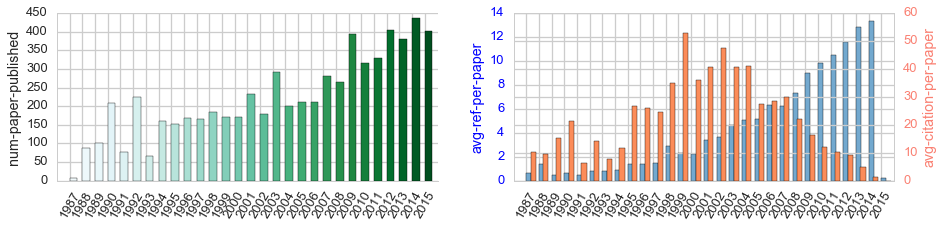

In [9]:
# data profile: # of papers published per year, citations per year

plt.figure(figsize=(15, 3))
cur_dpi=100
# # of papers over years; # of references and # of citations over years
# # of citings over years, w/wo venues; # of citing venues over years
# # of citations over publication years, w/wo venues; # of venues over years

bar_colrs1 = sns.color_palette("BuGn", len(paper_years))
bar_colrs2 = sns.color_palette("OrRd", len(paper_years))
bar_colrs3 = sns.color_palette("PuBu", len(paper_years))
mdx = int(len(bar_colrs1)/2) # index of the middle bar color
x_pos = [x+1 for x in range(len(paper_years))]

"""# papers per year"""

sns.set_context("talk", font_scale=1.)
sns.set_style("whitegrid")
sns.despine()

ax = plt.subplot(1, 2, 1)

rects1 = ax.bar(x_pos, np.array(paper_count), width=.6, color=bar_colrs1)
ax.set_ylabel('num-paper-published')
tk1 = plt.xticks(x_pos, paper_years, rotation=60) 

"""# of references and # of citations over years"""
ax2 = plt.subplot(1, 2, 2)

sns.set_style("whitegrid")
sns.despine()

rects2 = ax2.bar(x_pos, ref_pp, width=.4, color=bar_colrs3[mdx])

ax2a = ax2.twinx()
rects2a = ax2a.bar([x+.35 for x in x_pos], cit_pp, width=.4, color=bar_colrs2[mdx])

tk2 = plt.xticks([],[])
ax2.set_xticks(x_pos)
ax2.set_xticklabels(paper_years, rotation=60)

ax2.set_ylabel('avg-ref-per-paper', color='b')
ax2a.set_ylabel('avg-citation-per-paper', color='salmon')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
for tl in ax2a.get_yticklabels():
    tl.set_color('salmon') 

plt.savefig(os.path.join(plot_dir, conf, conf+'_cnt_paper.png'), dpi=cur_dpi, transparent=True)    

[3, 72, 32, 92, 28, 146, 41, 106, 153, 167, 201, 398, 292, 266, 606, 507, 1071, 826, 920, 1107, 1475, 1669, 3023, 2702, 2956, 3936, 4072, 4781, 74] [1, 49, 19, 36, 10, 36, 13, 37, 57, 58, 48, 135, 98, 114, 172, 137, 284, 194, 155, 230, 277, 275, 542, 416, 499, 745, 828, 1047, 12]


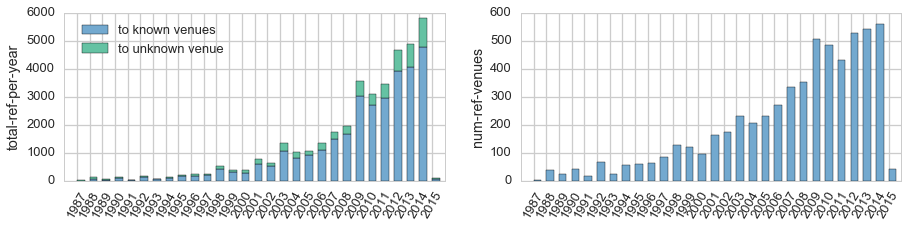

In [10]:
"""# of citings over years, w/wo venues; # of citing venues over years"""    
plt.figure(figsize=(15, 3))

ax3 = plt.subplot(1, 2, 1)
sns.set_context("talk", font_scale=1.)
sns.set_style("whitegrid")

citing_not_null = [] #np.zeros((1, len(years)), dtype=np.int)
citing_num_null = [] #np.zeros((len(years), 1), dtype=np.int)
cnt = 0 
for name, gf in df_citing.groupby(['PaperPubYear']):
    #print(gf.head())
    #print(len(gf), len ( gf['RefVenueID'][gf['RefVenueID'] != ''] ), len ( gf['RefVenueID'][gf['RefVenueID'] == ''] )) 
    citing_not_null.append( len ( gf['RefVenueID'][gf['RefVenueID'] != ''] ) )
    citing_num_null.append( len ( gf['RefVenueID'][gf['RefVenueID'] == ''] ) )
    
print(citing_not_null, citing_num_null)    

rects3a = ax3.bar(x_pos, citing_not_null, width=.6, color=bar_colrs3[mdx])
rects3b = ax3.bar(x_pos, citing_num_null, width=.6, color=bar_colrs1[mdx], bottom=citing_not_null)

tk3 = plt.xticks(x_pos, paper_years, rotation=60) 
ax3.set_ylabel('total-ref-per-year')
plt.legend((rects3a[0], rects3b[0]), 
           ('to known venues', 'to unknown venue'), bbox_to_anchor=(.45, 1))

ax4 = plt.subplot(1, 2, 2)
sns.set_style("whitegrid")

venue_counts = np.zeros( len(paper_years) )
for name, gf in df_citing[df_citing['RefVenueID'] != ''].groupby(['PaperPubYear']):
    idy = np.where(paper_years==name)
    if idy[0].size:
        venue_counts[idy] = len( gf['RefVenueID'].value_counts() )
    #venue_counts.append( len( gf['RefVenueID'].value_counts() ) )

rects4 = ax4.bar(x_pos, venue_counts, width=.6, color=bar_colrs3[mdx])

tk4 = plt.xticks(x_pos, paper_years, rotation=60)
ax4.set_ylabel('num-ref-venues')

plt.savefig(os.path.join(plot_dir, conf, conf+'_cnt_ref.png'), dpi=cur_dpi, transparent=True)    

[41, 592, 1068, 3059, 359, 2260, 349, 1267, 2802, 2954, 2821, 4697, 6270, 4199, 6504, 6048, 8553, 6006, 4239, 4320, 6347, 4235, 4676, 2735, 2475, 2720, 1312, 367, 9] [20, 247, 493, 1369, 123, 944, 152, 579, 1285, 1406, 1286, 1755, 2859, 1995, 2913, 2440, 3331, 2226, 1511, 1717, 2120, 1612, 1731, 1056, 956, 955, 542, 174, 1]
29 29


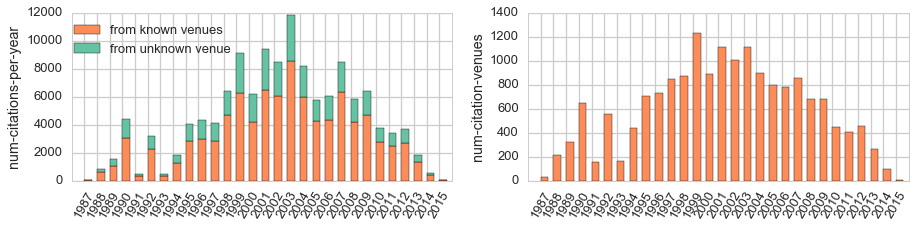

In [11]:
"""# of citations over publication years, w/wo venues; # of venues over years"""

plt.figure(figsize=(15, 3))

ax5 = plt.subplot(1, 2, 1)
sns.set_style("whitegrid")

citations_not_null = [] 
citations_num_null = [] 
for name, gf in df_cited.groupby(['RefPubYear']):
    #print(gf.head())
    # print(name, len(gf), len ( gf['PaperVenueID'][gf['PaperVenueID'] != ''] ), len ( gf['PaperVenueID'][gf['PaperVenueID'] == ''] )) 
    if name in paper_years:    
        citations_not_null.append( len ( gf['PaperVenueID'][gf['PaperVenueID'] != ''] ) )
        citations_num_null.append( len ( gf['PaperVenueID'][gf['PaperVenueID'] == ''] ) )
    
print(citations_not_null, citations_num_null)
print(len(citations_not_null), len(citations_num_null))


rects5a = ax5.bar(x_pos, citations_not_null, width=.6, color=bar_colrs2[mdx])
rects5b = ax5.bar(x_pos, citations_num_null, width=.6, color=bar_colrs1[mdx], bottom=citations_not_null)

tk5 = plt.xticks(x_pos, paper_years, rotation=60) 
ax5.set_ylabel('num-citations-per-year')
plt.legend((rects5a[0], rects5b[0]), 
           ('from known venues', 'from unknown venue'), bbox_to_anchor=(.45, 1))

ax6 = plt.subplot(1, 2, 2)
sns.set_style("whitegrid")

venue_counts = np.zeros( len(paper_years) )
for name, gf in df_cited[df_cited['PaperVenueID'] != ''].groupby(['RefPubYear']):
    idy = np.where(paper_years==name)
    if idy[0].size:
        venue_counts[idy] = len( gf['PaperVenueID'].value_counts() )
    #if name in paper_years:    
    #    venue_counts.append( len( gf['PaperVenueID'].value_counts() ) )

rects6 = ax6.bar(x_pos, venue_counts, width=.6, color=bar_colrs2[mdx])

tk6 = plt.xticks(x_pos, paper_years, rotation=60)
ax6.set_ylabel('num-citation-venues')

plt.savefig(os.path.join(plot_dir, conf, conf+'_cnt_citation.png'), dpi=cur_dpi, transparent=True)    

6483 paper papers from 1987 to 2016, citing 38246 others, avg 5.90 references per paper


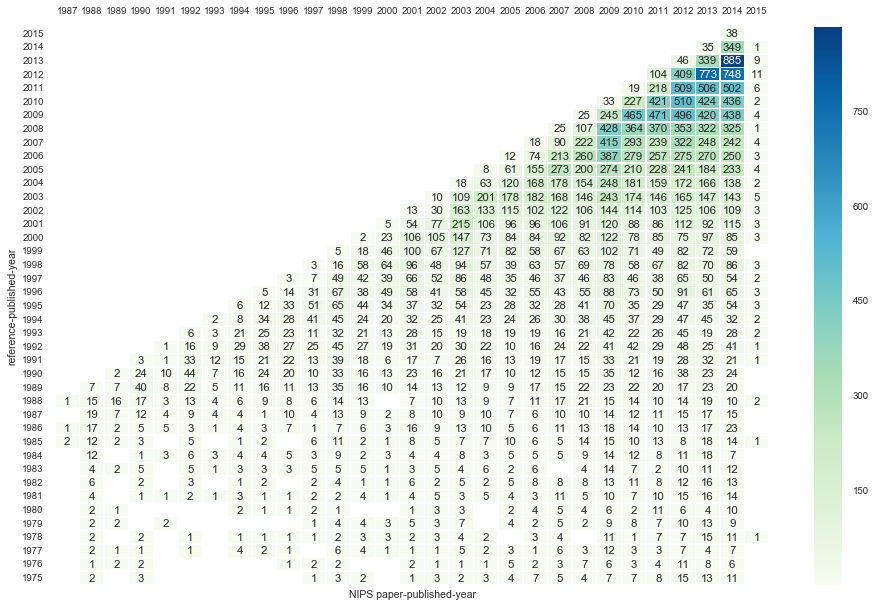

In [12]:
print('{} paper papers from {} to {}, citing {} others, avg {:0.2f} references per paper'.format(
        len(df_paper), df_paper['PubYear'].min(), df_paper['PubYear'].max(), len(df_citing), len(df_citing)/len(df_paper)))
grouped_citing = df_citing.groupby(['PaperPubYear'], sort=True)
grouped_citing.count()
len(grouped_citing)

refpubyear_count = pd.DataFrame(data=None, index=np.unique(df_citing['RefPubYear'] ), 
                                    columns=paper_years, dtype='int32')
for name, gf in grouped_citing:
    if name in paper_years:    
        refpubyear_count[name] = gf['RefPubYear'].value_counts(sort=True)
    #print("{}: {} references across {} years".format(name, len(gf), len(gf['RefPubYear'].value_counts())) )

plt.figure(figsize=(16, 10))
sns.set_context("poster", font_scale=0.6) #rc={"lines.linewidth": 2.5}

""" # the view of everthing
sns.heatmap(refpubyear_count, linewidths=.5, yticklabels=3)
ax.xaxis.tick_top()
ax.invert_yaxis()
sns.axlabel(conf + ' paper-published-year', 'reference-published-year')
"""

# the subset of reference years
ax = sns.heatmap(refpubyear_count.loc[1975:2015], linewidths=.5, annot=True, fmt=".0f", cmap="GnBu")
ax.xaxis.tick_top()
ax.invert_yaxis()
sns.axlabel(conf + ' paper-published-year', 'reference-published-year')

plt.savefig(os.path.join(plot_dir, conf, conf+'_year_ref.png'), transparent=True)


6483 paper papers from 1987 to 2016, cited 131082 time, avg 20.22 cites per paper


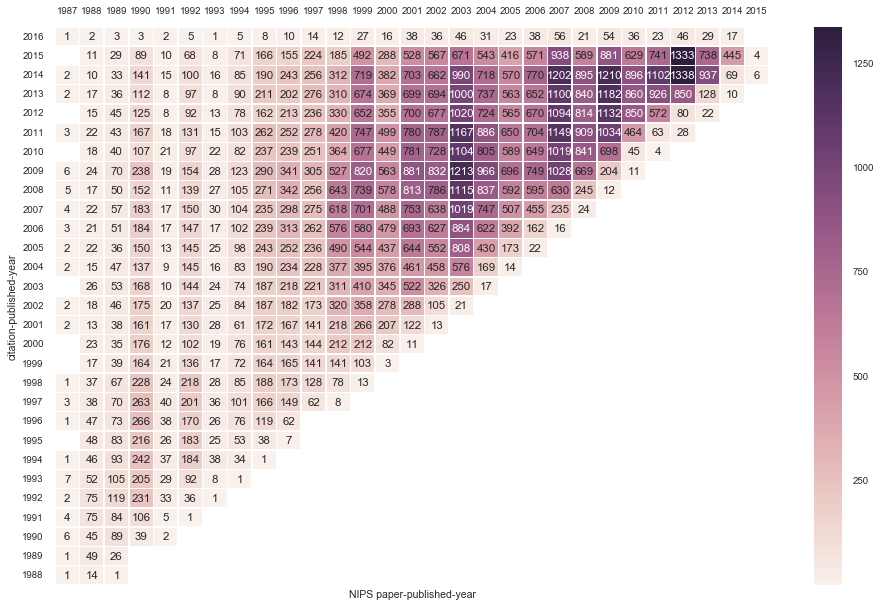

In [13]:
print('{} paper papers from {} to {}, cited {} time, avg {:0.2f} cites per paper'.format(
        len(df_paper), df_paper['PubYear'].min(), df_paper['PubYear'].max(), len(df_cited), len(df_cited)/len(df_paper)))
grouped_cited = df_cited.groupby(['RefPubYear'], sort=True)
#print( grouped_cited.count() )
#len(grouped_cited)

cite_pubyear_count = pd.DataFrame(data=None, index=np.unique(df_cited['PaperPubYear'] ), 
                                    columns=paper_years, dtype='int32')
for name, gf in grouped_cited:
    if name in paper_years:    
        cite_pubyear_count[name] = gf['PaperPubYear'].value_counts(sort=True)
    #print("{}: {} citations across {} years".format(name, len(gf), len(gf['PaperPubYear'].value_counts())) )
 
plt.figure(figsize=(16, 10))
sns.set_context("poster", font_scale=0.6) #rc={"lines.linewidth": 2.5}

ax = sns.heatmap(cite_pubyear_count.loc[1975:2016], linewidths=.5, annot=True, fmt=".0f")
sns.axlabel(conf + ' paper-published-year', 'citation-published-year')
ax.xaxis.tick_top()
ax.invert_yaxis()

plt.savefig(os.path.join(plot_dir, conf, conf+'_year_citation.png'), transparent=True)


37 top-25 venues, union of reference and citations.


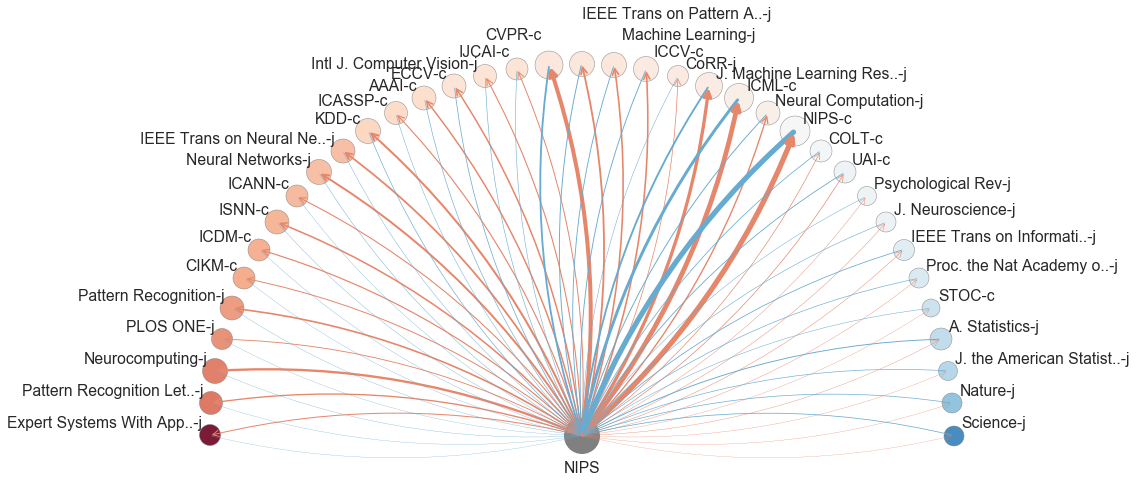

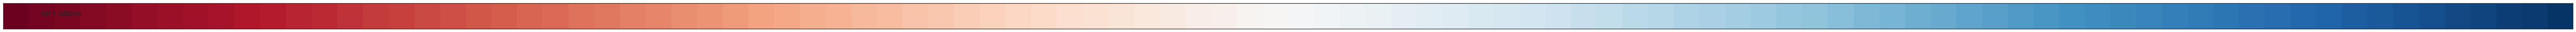

In [38]:
""" refs and citation data frames
PaperID     RefID  PaperPubYear  PaperConfID  RefPubYear RefVenueID
0  01C7AF88  5DF47FD5          2014      4332078        2005           
1  0419D273  69802989          2013      4332078        1983           
2  04C8255A  707FA05D          2011      4332078        2008   46A355BA
3  06E27F4E  5D781F7D          2014      4332078        2000    5686292
4  07E16ECA  5ACD83EA          2012      4332078        2005   4332078E

PaperID     RefID  RefPubYear  RefConfID  PaperPubYear PaperVenueID
0  0007A307  6F46CC0D        2000    4332078          2003             
1  001D62B0  5C4CC440        2002    4332078          2014     0140E2D3
2  002545D4  685D7FC2        1999    4332078          2005             
3  002E73A6  6978437E        2007    4332078          2009             
4  004344D3  5CCE3A13        1990    4332078          1991             

goal of this sec: groupby venue and count
"""

topK = 25 #50 
numRef = len(df_citing)
numCite = len(df_cited)

# figure out the top venues for both ref and citations
gv_citing = df_citing.groupby(['RefVenueID'], sort=True)
venue_ref_cnt = gv_citing['PaperID'].count().sort_values(ascending=False)
allvenue_ref = [s for s in venue_ref_cnt.index if len(s)]

gv_cited = df_cited.groupby(['PaperVenueID'], sort=True)
venue_citation_cnt = gv_cited['PaperID'].count().sort_values(ascending=False)
allvenue_citation = [s for s in venue_citation_cnt.index if len(s)]

venue_topK = list(set(allvenue_ref[:topK] + allvenue_citation[:topK]))
print('{} top-{} venues, union of reference and citations.'.format(len(venue_topK), topK) )

# build a graph structure for the above

venueG = nx.DiGraph()
refG = nx.DiGraph()
citeG = nx.DiGraph()

venue_metric = dict()
venue_ref = dict()
venue_citation = dict()

"""
    construct venue graphs, and 
    compute the in/out citation metric 
"""
for v in venue_topK:
    vname = id2display[v]
    r = venue_ref_cnt[v]
    refG.add_edge(conf, vname, weight= int(r) )
    venueG.add_edge(conf, vname, weight= float(r/numRef) )
    
    c = venue_citation_cnt[v]
    citeG.add_edge(vname, conf, weight= int(c) )
    venueG.add_edge(vname, conf, weight= float(c/numCite) )
    
    # visualization and meta attributes 
    venue_ref[vname] = float(r) #float(r/numRef)
    venue_citation[vname] = float(c) #float(c/numCite)
    venue_metric[vname] = float(r)/c #float(r/numRef) / float(c/numCite)

nx.set_node_attributes(venueG, 'citation_out', venue_ref)
nx.set_node_attributes(venueG, 'citation_in', venue_citation)
nx.set_node_attributes(venueG, 'citation_flow', venue_metric)

#nx.write_graphml(venueG, os.path.join(data_dir, 'citeG.'+conf+'.graphml'))
#nx.write_gexf(venueG, os.path.join(data_dir, 'citeG.'+conf+'.gexf'))

# plot the above info as a graph with curved edges
#import matplotlib.patches as mpatches
from matplotlib import gridspec

fig = plt.figure(figsize=(16, 8))
sns.set_context("talk", font_scale=1.)
sns.set_style("white")
sns.despine()
ax = fig.add_subplot(111)

max_marker = 30
max_line = 5.
min_line = 0.25

num_clrs = 100
dot_colors = sns.color_palette("RdBu", num_clrs)
out_edge_color = dot_colors[round(3*num_clrs/4)] #{'r':32, 'g':32, 'b':192}
in_edge_color = dot_colors[round(1*num_clrs/4)] #{'r':192, 'g':32, 'b':32}

metric_max = max( [np.abs(np.log10(v)) for v in venue_metric.values()] )
ref_max = max( venue_ref.values() )
cite_max = max( venue_citation.values() )
vol_max = max( [r+c for (r, c) in zip(venue_ref.values(), venue_citation.values())] )
delta_text = 0.02 

# plot the root node
#node_viz[conf] = {'size': flowmax*1.25, 'position':{'x': 0, 'y':0, 'z':0}}
xroot = 0.
yroot = 0.
ax.plot(xroot, yroot, 'o', c=[.5, .5, .5], markersize=1.2*max_marker, fillstyle='full', mec='0.5')
ax.text(xroot, yroot-5*delta_text, conf, horizontalalignment='center')
#ax.annotate(conf, xy=(0, 0), xytext=(0, -.1), horizontalalignment='left',
#            verticalalignment='bottom')

# generate the layout and plot
isort = list(np.argsort([venue_metric[id2display[v]] for v in venue_topK]))
anglelist = np.linspace(np.pi, 0., num=len(isort))
#for v in venue_topK:
for i,j in enumerate(isort):
    v = venue_topK[j]
    vn = id2display[v]
    xp = np.cos(anglelist[i]) #np.log10(venue_metric[vn])/metric_max
    yp = np.sin(np.abs(anglelist[i])) # np.random.random() 
    
    # figure out what color and size of the node
    sz = np.round( max_marker * np.log(venue_ref[vn]+venue_citation[vn])/np.log(vol_max) )
    ci = np.log10(venue_metric[vn])/metric_max * num_clrs/2 + num_clrs/2
    #print(anglelist[i], xp, yp, sz, ci, int(ci) )
    
    # figure out width of the lines
    in_lw = max_line * venue_ref[vn]/ref_max + min_line
    out_lw = max_line * venue_citation[vn]/ref_max + min_line
    
    # draw connectors/arcs
    ax.annotate("", xy=(xroot, yroot), xycoords='data',
            xytext=(xp, yp), textcoords='data',
            arrowprops=dict(arrowstyle="-", #linestyle="dashed",
                            color=out_edge_color, linewidth=in_lw,
                            connectionstyle="arc3,rad=0.12", ), )

    ax.annotate("", xy=(xp, yp), xycoords='data',
            xytext=(xroot, yroot), textcoords='data',
            arrowprops=dict(arrowstyle="->", #linestyle="dashed",
                            color=in_edge_color, linewidth=out_lw,
                            connectionstyle="arc3,rad=0.12",),)

    # draw the node
    ax.plot(xp, yp, 'o', c=dot_colors[int(ci)], markersize=int(sz), 
            alpha=.9, mec='0.5', mew=.5) 

    
    # add text labels
    if np.abs(xp)>1e-6 and np.abs(xp)<0.2 :
        yt = yp + .3*delta_text/np.abs(xp)
    else:
        yt = yp + delta_text

    if np.abs(xp)<1e-6:
        xt = xp 
        yt = yp + 6*delta_text
        halign = 'left'
    elif xp>0:
        xt = xp + delta_text
        halign = 'left'
    else:
        xt = xp - delta_text
        halign = 'right'
    
    ax.text(xt, yt, vn, horizontalalignment=halign)

ax.set_xlim((-1.2, 1.2))
ax.set_ylim((-.1, 1.1))
ax.axis('off')

plt.savefig(os.path.join(plot_dir, conf, conf+'_graph.png'), dpi=cur_dpi, transparent=True)

fig = plt.figure(figsize=(6, 2))
sns.palplot(dot_colors)
axt = plt.gca()
axt.axis('on')
axt.text(1, 0, 'ref > citation', horizontalalignment='left')

plt.savefig(os.path.join(plot_dir, conf, 'color_bar.png'), dpi=cur_dpi, transparent=True)

#plt.show()

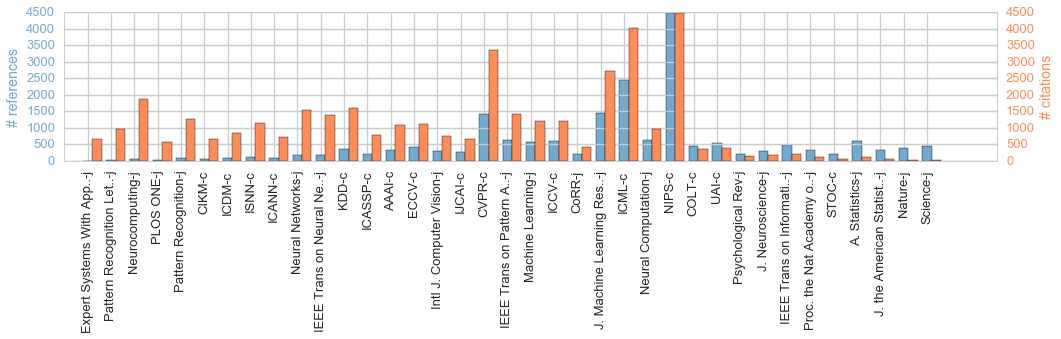

In [39]:
# generate bar graphs visualizing overall in/out citation volume
plt.figure(figsize=(15, 5))
sns.set_context("talk", font_scale=1.) #rc={"lines.linewidth": 2.5}
sns.set_style("whitegrid")
sns.despine()

isort = list(np.argsort([venue_metric[id2display[v]] for v in venue_topK]))
sorted_name_list = [id2display[venue_topK[i]] for i in isort]
x_venues = [x+1 for x in range(len(venue_topK))]

ax2 = plt.subplot(1,1,1)

vbar = ax2.bar([x-.2 for x in x_venues], [venue_ref[v] for v in sorted_name_list], 
                width=.4, color=bar_colrs3[mdx])

ax2a = ax2.twinx()
vbara = ax2a.bar([x+.2 for x in x_venues], [venue_citation[v] for v in sorted_name_list], 
                   width=.4, color=bar_colrs2[mdx])

tk2 = plt.xticks([],[])
ax2.set_xticks(x_venues)
ax2.set_xticklabels(sorted_name_list, rotation=90)

ax2.set_ylabel('# references', color=bar_colrs3[mdx])
ax2a.set_ylabel('# citations', color=bar_colrs2[mdx])
for tl in ax2.get_yticklabels():
    tl.set_color(bar_colrs3[mdx])
for tl in ax2a.get_yticklabels():
    tl.set_color(bar_colrs2[mdx]) 
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, conf, conf+'_venue_bar.png'), dpi=cur_dpi, transparent=True)

In [40]:
# accumulate counts for refrences
refvenue_count = pd.DataFrame(data=None, dtype='int32', index = allvenue_ref, columns = paper_years)

for name, gf in grouped_citing:
    if name in paper_years:    
        refvenue_count[name] = gf['RefVenueID'].value_counts(sort=True)


# accumulate counts for citations
citevenue_count = pd.DataFrame(data=None, index = allvenue_citation, columns = paper_years, dtype='int32')
for name, gf in grouped_cited:
    if name in paper_years:    
        citevenue_count[name] = gf['PaperVenueID'].value_counts(sort=True)
    

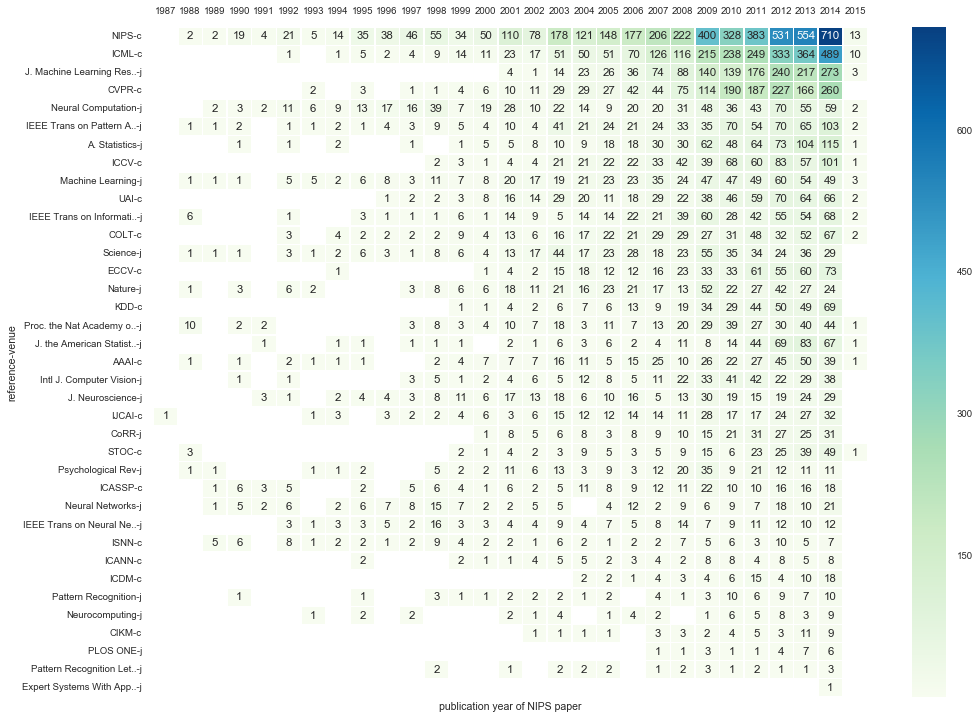

In [41]:
# amount of references over time 
plt.figure(figsize=(16, 12))
sns.set_context("poster", font_scale=0.6)

jsort = list(np.argsort([venue_ref[id2display[v]] for v in venue_topK]))
jsort.reverse()
sorted_vlist = [id2display[venue_topK[j]] for j in jsort]
sorted_vid = [venue_topK[j] for j in jsort]

ax = sns.heatmap(refvenue_count.loc[sorted_vid], linewidths=.5, annot=True, fmt=".0f", cmap="GnBu") 
ax.xaxis.tick_top()
sns.axlabel('publication year of ' + conf + ' paper', 'reference-venue')

yt = ax.set_yticklabels(sorted_vlist[::-1])

plt.savefig(os.path.join(plot_dir, conf, conf+'_venue_ref.png'), transparent=True)

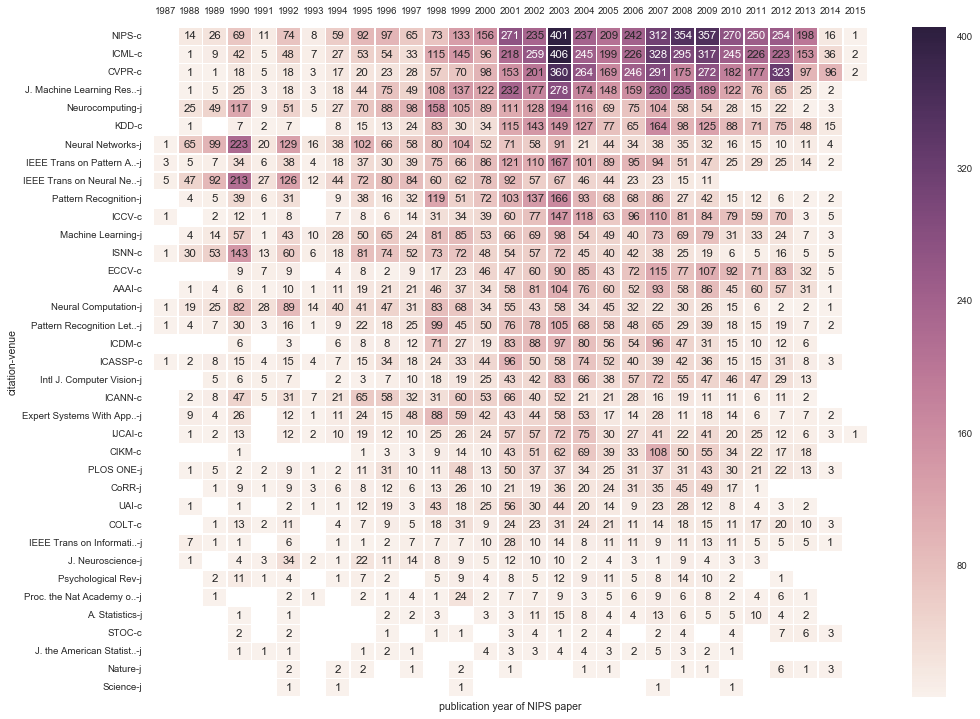

In [42]:
# amount of citations over time 
plt.figure(figsize=(16, 12))
sns.set_context("poster", font_scale=0.6)

jsort = list(np.argsort([venue_citation[id2display[v]] for v in venue_topK]))
jsort.reverse()
sorted_vlist = [id2display[venue_topK[j]] for j in jsort]
sorted_vid = [venue_topK[j] for j in jsort]

ax = sns.heatmap(citevenue_count.loc[sorted_vid], linewidths=.5, annot=True, fmt=".0f") 
ax.xaxis.tick_top()
sns.axlabel('publication year of ' + conf + ' paper', 'citation-venue')

yt = ax.set_yticklabels(sorted_vlist[::-1])

plt.savefig(os.path.join(plot_dir, conf, conf+'_venue_citation.png'), transparent=True)

In [81]:
## TODO: code to write markdown posts

""" 
name of the post file, and couple of other variables
"""

post_file = os.path.join(post_dir, conf+".md")
img_path = "/img/citation"
conf_full_name = list(conf_df["FullName"][conf_df['Abbrv']==conf])[0]
img_width = 820

ph = open(post_file, "wt")

"""  write header for the post
---
title: "Media and News"
description: "An archive of what others and ourselves think are news-worthy."
date: "2016-01-02"
categories:
  - "misc"
tags:
  - "cm"
---
"""
ph.write("---\n")
ph.write('title: "{} -- {} ({} - {})"\n'.format(conf, conf_full_name, paper_years[0], paper_years[-1]))
ph.write('description: "Citation pattern plots and analysis for {} - {} conference."\n'.format(conf, conf_full_name))
ph.write('date: "{}"\n'.format(datetime.now()))
ph.write('categories:\n  - "data"\n  - "pilot"\n')
ph.write('tags:\n  - "citation"\n  - "datasci"\n  - "graph"\n')
ph.write("---\n\n")

""" write basic stats
"""

ph.write('Stats:\n\n')
ph.write('* {} years of publication {}--{}, {} papers total\n'.format(len(paper_years), paper_years[0], paper_years[-1], len(df_paper)))
ph.write('* {} references total, average {} per paper\n'.format(len(df_citing), round(1.*len(df_citing)/len(df_paper), 2)) )
ph.write('* {} citations total, average {} per paper\n'.format(len(df_cited), round(1.*len(df_cited)/len(df_paper), 2) ))
ph.write(" \n\n")

""" write figures 
"""
ph.write("### Plots of citation data\n")
# a list of figures in their order of appearance 
fig_key = ['cnt_paper', 'cnt_ref', 'cnt_citation', 
           'venue_bar', 'venue_ref', 'venue_citation', 'year_ref', 'year_citation']
fig_info = json.load(open(os.path.join(plot_dir, 'fig_text.json'), 'rt'))

for i in range(len(fig_key)):
    fn = fig_key[i]
    if fn in fig_info:
        info = fig_info[fn]
    else:
        info = ""
    ph.write('Fig {}. {}\n'.format(i+1, info) )
    ph.write('<img width={} src="{}">\n'.format(img_width, os.path.join(img_path, conf, conf+'_'+fn+'.png')))
    ph.write('\n')

ph.close()

In [95]:

G=nx.path_graph(4)
nx.write_gexf(G, os.path.join(plot_dir,"test.gexf"))


G1 = nx.read_gexf(os.path.join(plot_dir,"test.gexf"))
G1.nodes()
nx.get_node_attributes(G1, 'viz')

['0', '3', '2', '1']

(0.85767013535780068, 0.41891581112263249, 0.33456364390896814)

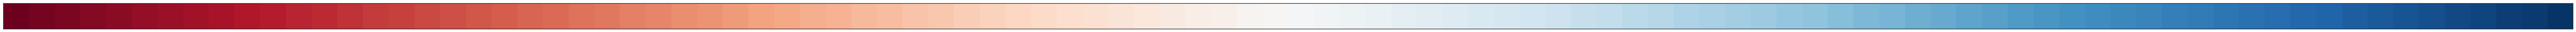

In [65]:
sns.palplot(dot_colors)
dot_colors[21]

In [82]:
np.cos(anglelist)

array([ -1.00000000e+00,  -9.96194698e-01,  -9.84807753e-01,
        -9.65925826e-01,  -9.39692621e-01,  -9.06307787e-01,
        -8.66025404e-01,  -8.19152044e-01,  -7.66044443e-01,
        -7.07106781e-01,  -6.42787610e-01,  -5.73576436e-01,
        -5.00000000e-01,  -4.22618262e-01,  -3.42020143e-01,
        -2.58819045e-01,  -1.73648178e-01,  -8.71557427e-02,
         6.12323400e-17,   8.71557427e-02,   1.73648178e-01,
         2.58819045e-01,   3.42020143e-01,   4.22618262e-01,
         5.00000000e-01,   5.73576436e-01,   6.42787610e-01,
         7.07106781e-01,   7.66044443e-01,   8.19152044e-01,
         8.66025404e-01,   9.06307787e-01,   9.39692621e-01,
         9.65925826e-01,   9.84807753e-01,   9.96194698e-01,
         1.00000000e+00])

In [ ]:

""" set visualization attributes
nx.get_node_attributes(G1, 'viz')

{'0': {'color': {'b': 66, 'g': 173, 'r': 239},
  'position': {'x': 15.783598, 'y': 40.109245, 'z': 0.0},
  'shape': None,
  'size': 2.0375757}}
"""
"""  ########### the code below doesn't work in gephi, draw from scratch below ###########
node_viz = {}
edge_viz = {}
flowmax = max( [np.abs(np.log10(v)) for v in venue_metric.values()] )
out_edge_color = {'r':32, 'g':32, 'b':192}
in_edge_color = {'r':192, 'g':32, 'b':32}
for v in venue_topK:
    vn = id2display[v]
    xp = np.log10(venue_metric[vn])/flowmax
    yp = np.random.random() * np.sin(np.arccos(np.abs(xp)))
    node_viz[vn] = {'size': venue_ref[vn]+venue_citation[vn], 
                        'position':{'x': xp, 'y':yp, 'z':0}}
    edge_viz[(conf, vn)] = {'color':out_edge_color, 'thickness':venueG.edge[conf][vn]['weight']}
    edge_viz[(vn, conf)] = {'color':in_edge_color, 'thickness':venueG.edge[vn][conf]['weight']}

node_viz[conf] = {'size': flowmax*1.25, 'position':{'x': 0, 'y':0, 'z':0}}

nx.set_node_attributes(venueG, 'viz', node_viz)
nx.set_edge_attributes(venueG, 'viz', edge_viz)
"""